In [134]:
import sys
sys.path.append('/home/codespace/.local/lib/python3.10/site-packages')

In [135]:
import numpy as np
import pandas as pd
from PIL import Image
import os
import csv
import matplotlib.pyplot as plt
import math
import random
import torch

In [136]:
#import relevant variables from Berkley assignment

TEST_SET_SIZE = 100
DIGIT_DATUM_WIDTH=28
DIGIT_DATUM_HEIGHT=28
DIGIT_IMAGE_LENGTH=784
FACE_DATUM_WIDTH=60
digit_DATUM_HEIGHT=70
digit_IMAGE_LENGTH=4200
value_dict = {' ': 0, '#': 1, '+': 1}

In [137]:
class ImageDataset():
    def __init__(self, data_dir):
        self.data_dir = data_dir

        self.image_files = [f"{i}.png" for i in range(1, len(os.listdir(data_dir)))]  # Assuming there's 1 labels.csv file
        self.labels = []

        with open(os.path.join(data_dir, "labels.csv"), "r") as csvfile:
            csv_reader = csv.reader(csvfile)
            for row in csv_reader:
                self.labels.append(int(row[0]))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_path).convert("L")
        image = np.array(image)
        image[image== 0] = 1
        image[image== 255] = 0

        label = self.labels[idx]

        return image, label

In [138]:
train_data_digit = ImageDataset("digitdata/processed/training")
test_data_digit = ImageDataset("digitdata/processed/test")
validation_data_digit = ImageDataset("digitdata/processed/validation")

train_data_face = ImageDataset("facedata/processed/facedatatrain")
test_data_face = ImageDataset("facedata/processed/facedatatest")
validation_data_face = ImageDataset("facedata/processed/facedatavalidation")

print(train_data_digit.labels)
print(train_data_face.labels)

[5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9, 3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5, 6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9, 0, 2, 6, 7, 8, 3, 9, 0, 4, 6, 7, 4, 6, 8, 0, 7, 8, 3, 1, 5, 7, 1, 7, 1, 1, 6, 3, 0, 2, 9, 3, 1, 1, 0, 4, 9, 2, 0, 0, 2, 0, 2, 7, 1, 8, 6, 4, 1, 6, 3, 4, 5, 9, 1, 3, 3, 8, 5, 4, 7, 7, 4, 2, 8, 5, 8, 6, 7, 3, 4, 6, 1, 9, 9, 6, 0, 3, 7, 2, 8, 2, 9, 4, 4, 6, 4, 9, 7, 0, 9, 2, 9, 5, 1, 5, 9, 1, 2, 3, 2, 3, 5, 9, 1, 7, 6, 2, 8, 2, 2, 5, 0, 7, 4, 9, 7, 8, 3, 2, 1, 1, 8, 3, 6, 1, 0, 3, 1, 0, 0, 1, 7, 2, 7, 3, 0, 4, 6, 5, 2, 6, 4, 7, 1, 8, 9, 9, 3, 0, 7, 1, 0, 2, 0, 3, 5, 4, 6, 5, 8, 6, 3, 7, 5, 8, 0, 9, 1, 0, 3, 1, 2, 2, 3, 3, 6, 4, 7, 5, 0, 6, 2, 7, 9, 8, 5, 9, 2, 1, 1, 4, 4, 5, 6, 4, 1, 2, 5, 3, 9, 3, 9, 0, 5, 9, 6, 5, 7, 4, 1, 3, 4, 0, 4, 8, 0, 4, 3, 6, 8, 7, 6, 0, 9, 7, 5, 7, 2, 1, 1, 6, 8, 9, 4, 1, 5, 2, 2, 9, 0, 3, 9, 6, 7, 2, 0, 3, 5, 4, 3, 6, 5, 

In [139]:
# Set the number of distinct for digits

partition = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
def partitionData(train_data, partition):
    train_data_partitioned, _ = torch.utils.data.random_split(train_data, [int((len(train_data)*partition)), len(train_data) - int((len(train_data)*partition))])
    return train_data_partitioned

train_data_digit = partitionData(train_data_digit, 1)
train_data_face = partitionData(train_data_face, 1)

In [140]:
class NaiveBayesClassifier:
    def __init__(self):
        self.priors = None
        self.likelihoods = None

    def fit(self, X, y, alpha=1):
        num_classes = len(np.unique(y))
        num_features = X.shape[1]

        self.priors = np.zeros(num_classes)
        self.likelihoods = np.zeros((num_classes, num_features, 2))

        for c in range(num_classes):
            X_c = X[y == c]
            self.priors[c] = len(X_c) / len(X)
            
            for f in range(num_features):
                # Apply Laplace smoothing to the likelihood calculations
                self.likelihoods[c, f, 0] = (np.sum(X_c[:, f] == 0) + alpha) / (len(X_c) + alpha * 2)
                self.likelihoods[c, f, 1] = (np.sum(X_c[:, f] == 1) + alpha) / (len(X_c) + alpha * 2)

    def predict(self, X):
        log_probs = np.zeros((len(X), len(self.priors)))

        for c in range(len(self.priors)):
            for f in range(X.shape[1]):
                log_probs[:, c] += np.log(self.likelihoods[c, f, X[:, f]])
            log_probs[:, c] += np.log(self.priors[c])
        
        return np.argmax(log_probs, axis=1)

def preprocess_data(data):
    X = np.array([img.flatten() for img, _ in data])
    y = np.array([label for _, label in data])
    return X, y


In [141]:
train_data_face = ImageDataset("facedata/processed/facedatatrain")
test_data_face = ImageDataset("facedata/processed/facedatatest")
validation_data_face = ImageDataset("facedata/processed/facedatavalidation")

X_train, y_train = preprocess_data(train_data_face)
X_valid, y_valid = preprocess_data(validation_data_face)
X_test, y_test = preprocess_data(test_data_face)

smoothing = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
accuracies1 = []

# test smoothing parameter on validation data
for k in smoothing:
    clf_face = NaiveBayesClassifier()
    print(f"k: {k}")
    clf_face.fit(X_train, y_train, alpha=k)
    y_pred = clf_face.predict(X_valid)
    accuracy = np.mean(y_pred == y_valid)
    print(f"Accuracy: {accuracy:.4f}")
    accuracies1.append(accuracy)

best_k = smoothing[accuracies1.index(max(accuracies1))]
print("Best k: ",best_k)



k: 0.001
Accuracy: 0.8837
k: 0.01
Accuracy: 0.8837
k: 0.05
Accuracy: 0.8837
k: 0.1
Accuracy: 0.8837
k: 0.5
Accuracy: 0.8704
k: 1
Accuracy: 0.8704
k: 5
Accuracy: 0.8372
k: 10
Accuracy: 0.8040
k: 20
Accuracy: 0.7409
k: 50
Accuracy: 0.7309
Best k:  0.001


Now, lets test the data and training time over all the different partitions we can make

In [142]:
def partitionData(train_data, partition):
    train_data_partitioned, _ = torch.utils.data.random_split(train_data, [int((len(train_data)*partition)), len(train_data) - int((len(train_data)*partition))])
    return train_data_partitioned

In [143]:
#Warm up run
train_data_face_warmup = ImageDataset("facedata/processed/facedatatrain")
train_data_face_warmup = partitionData(train_data_face_warmup, 0.01)
X_train_warmup, y_train_warmup = preprocess_data(train_data_face_warmup)
clf_warmup = NaiveBayesClassifier()
clf_warmup.fit(X_train_warmup, y_train_warmup, alpha=0.1)


partitions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_face = {}
accuracies3 = []
times3 = []
import time

test_data_face = ImageDataset("facedata/processed/facedatatest")  # Define test_data_face

# Train a new model on the face dataset for different training set sizes
for partition in partitions:
    train_data_face = ImageDataset("facedata/processed/facedatatrain")
    train_data_face = partitionData(train_data_face, partition)

    start_time = time.time()
    X_train, y_train = preprocess_data(train_data_face)  # Use train_data_face
    X_test, y_test = preprocess_data(test_data_face)  # Use test_data_face

    print(f"Partition: {partition}")
    clf = NaiveBayesClassifier()
    clf.fit(X_train, y_train, alpha=1)
    y_pred = clf.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    end_time = time.time()
    times3.append(end_time - start_time)
    accuracies3.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")


Partition: 0.1
Accuracy: 0.7600
Partition: 0.2
Accuracy: 0.8400
Partition: 0.3
Accuracy: 0.8333
Partition: 0.4
Accuracy: 0.8733
Partition: 0.5
Accuracy: 0.8733
Partition: 0.6
Accuracy: 0.8733
Partition: 0.7
Accuracy: 0.8867
Partition: 0.8
Accuracy: 0.8800
Partition: 0.9
Accuracy: 0.9067
Partition: 1.0
Accuracy: 0.9067


Now, lets test out the digits dataset

In [144]:
train_data_digit = ImageDataset("digitdata/processed/training")
test_data_digit = ImageDataset("digitdata/processed/test")

X_train, y_train = preprocess_data(train_data_digit)
X_test, y_test = preprocess_data(test_data_digit)

smoothing = [0.001, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
accuracies2 = []

for k in smoothing:
    clf = NaiveBayesClassifier()
    print(f"k: {k}")
    clf.fit(X_train, y_train, alpha=k)
    y_pred = clf.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    print(f"Accuracy: {accuracy:.4f}")
    accuracies2.append(accuracy)

best_k = smoothing[accuracies2.index(max(accuracies2))]
print("Best k: ",best_k)

k: 0.001
Accuracy: 0.7620
k: 0.01
Accuracy: 0.7580
k: 0.05
Accuracy: 0.7570
k: 0.1
Accuracy: 0.7570
k: 0.5
Accuracy: 0.7500
k: 1
Accuracy: 0.7470
k: 5
Accuracy: 0.7360
k: 10
Accuracy: 0.7250
k: 20
Accuracy: 0.7080
k: 50
Accuracy: 0.6360
Best k:  0.001


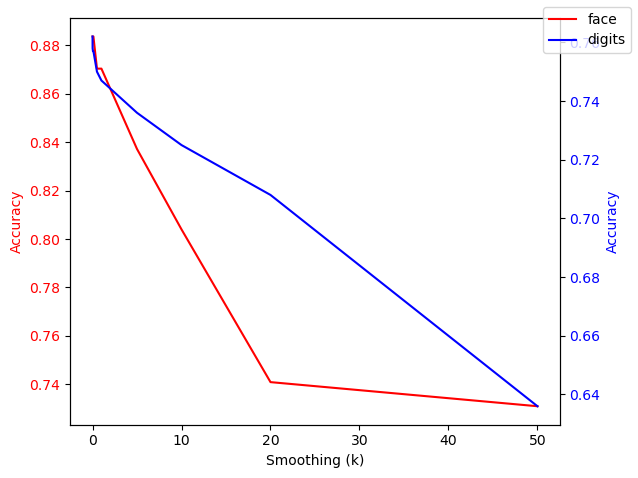

In [145]:
# plot the accuracies versus the alphas for all the data
fig, ax1 = plt.subplots()

ax1.set_xlabel("Smoothing (k)")
ax1.set_ylabel("Accuracy", color = 'r')
ax1.plot(smoothing, accuracies1, color = 'r', label = "face")
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy', color='b')  # we already handled the x-label with ax1
ax2.plot(smoothing, accuracies2, color='b', label = "digits")
ax2.tick_params(axis='y', labelcolor='b')
fig.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [146]:
#Warm up run
train_data_digit_warmup = ImageDataset("digitdata/processed/training")
train_data_digit_warmup = partitionData(train_data_digit_warmup, 0.01)
X_train_warmup, y_train_warmup = preprocess_data(train_data_digit_warmup)
clf_warmup = NaiveBayesClassifier()
clf_warmup.fit(X_train_warmup, y_train_warmup, alpha=best_k)


partitions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
results_face = {}
accuracies4 = []
times4 = []
import time

test_data_digit = ImageDataset("digitdata/processed/test") # Define test_data_digit

# Train a new model on the face dataset for different training set sizes
for partition in partitions:
    train_data_digit = ImageDataset("digitdata/processed/training")
    train_data_digit = partitionData(train_data_digit, partition)

    start_time = time.time()
    X_train, y_train = preprocess_data(train_data_digit)  # Use train_data_face
    X_test, y_test = preprocess_data(test_data_digit)  # Use test_data_face

    print(f"Partition: {partition}")
    clf = NaiveBayesClassifier()
    clf.fit(X_train, y_train, alpha=best_k)
    y_pred = clf.predict(X_test)
    accuracy = np.mean(y_pred == y_test)
    end_time = time.time()
    times4.append(end_time - start_time)
    accuracies4.append(accuracy)
    print(f"Accuracy: {accuracy:.4f}")


Partition: 0.1
Accuracy: 0.7430
Partition: 0.2
Accuracy: 0.7540
Partition: 0.3
Accuracy: 0.7610
Partition: 0.4
Accuracy: 0.7590
Partition: 0.5
Accuracy: 0.7580
Partition: 0.6
Accuracy: 0.7680
Partition: 0.7
Accuracy: 0.7510
Partition: 0.8
Accuracy: 0.7520
Partition: 0.9
Accuracy: 0.7630
Partition: 1.0
Accuracy: 0.7620


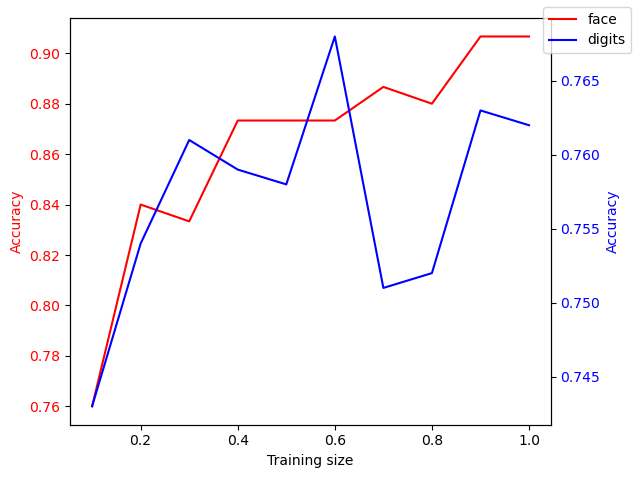

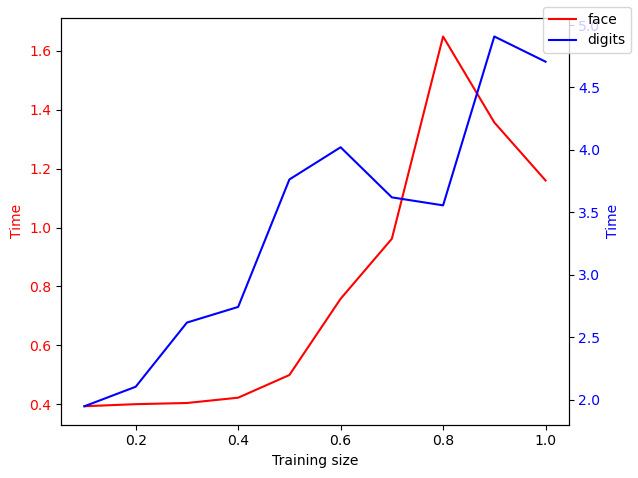

In [147]:
# Plot accuracy versus training set size

# plt.plot(partitions, accuracies1)
# plt.xlabel("Training set size")
# plt.ylabel("Accuracy")
# plt.title("Accuracy vs Training set size")
# plt.show()

# # Plot time versus training set size

# plt.plot(partitions1, times)
# plt.xlabel("Training set size")
# plt.ylabel("Time")
# plt.title("Time vs Training set size")
# plt.show()


fig, ax1 = plt.subplots()

ax1.set_xlabel("Training size")
ax1.set_ylabel("Accuracy", color = 'r')
ax1.plot(partitions, accuracies3, color = 'r', label = "face")
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Accuracy', color='b')  # we already handled the x-label with ax1
ax2.plot(partitions, accuracies4, color='b', label = "digits")
ax2.tick_params(axis='y', labelcolor='b')
fig.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


fig, ax1 = plt.subplots()

ax1.set_xlabel("Training size")
ax1.set_ylabel("Time", color = 'r')
ax1.plot(partitions, times3, color = 'r', label = "face")
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Time', color='b')  # we already handled the x-label with ax1
ax2.plot(partitions, times4, color='b', label = "digits")
ax2.tick_params(axis='y', labelcolor='b')
fig.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

Now Lets get the standard deviation for both digits and faces

In [148]:
import time

partitions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_runs = 5  # Number of runs for each partition size
accuracies = []

test_data_face = ImageDataset("facedata/processed/facedatatest")

for partition in partitions:
    partition_accuracies = []

    for _ in range(num_runs):
        train_data_face = ImageDataset("facedata/processed/facedatatrain")
        train_data_face = partitionData(train_data_face, partition)

        X_train, y_train = preprocess_data(train_data_face)
        X_test, y_test = preprocess_data(test_data_face)

        clf = NaiveBayesClassifier()
        clf.fit(X_train, y_train, alpha=best_k)
        y_pred = clf.predict(X_test)
        accuracy = np.mean(y_pred == y_test)

        partition_accuracies.append(accuracy)

    accuracies.append(partition_accuracies)

# Compute standard deviation of accuracy for each partition size
accuracy_std = [np.std(partition_accuracies) for partition_accuracies in accuracies]

for i, partition in enumerate(partitions):
    print(f"Partition: {partition}, Standard deviation of accuracy: {accuracy_std[i]:.4f}")


Partition: 0.1, Standard deviation of accuracy: 0.0737
Partition: 0.2, Standard deviation of accuracy: 0.0514
Partition: 0.3, Standard deviation of accuracy: 0.0320
Partition: 0.4, Standard deviation of accuracy: 0.0140
Partition: 0.5, Standard deviation of accuracy: 0.0124
Partition: 0.6, Standard deviation of accuracy: 0.0142
Partition: 0.7, Standard deviation of accuracy: 0.0122
Partition: 0.8, Standard deviation of accuracy: 0.0225
Partition: 0.9, Standard deviation of accuracy: 0.0060
Partition: 1.0, Standard deviation of accuracy: 0.0000


In [149]:
import numpy as np
import time

partitions = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
num_runs = 5  # Number of runs for each partition size
accuracies2 = []

test_data_digit = ImageDataset("digitdata/processed/test") # Define test_data_digit

for partition in partitions:
    partition_accuracies2 = []

    for _ in range(num_runs):
        train_data_digit = ImageDataset("digitdata/processed/training") # Define test_data_digit
        train_data_digit = partitionData(train_data_digit, partition)

        X_train, y_train = preprocess_data(train_data_digit)
        X_test, y_test = preprocess_data(test_data_digit)

        clf = NaiveBayesClassifier()
        clf.fit(X_train, y_train, alpha=best_k)
        y_pred = clf.predict(X_test)
        accuracy = np.mean(y_pred == y_test)

        partition_accuracies2.append(accuracy)

    accuracies2.append(partition_accuracies2)

# Compute standard deviation of accuracy for each partition size
accuracy_std2 = [np.std(partition_accuracies2) for partition_accuracies2 in accuracies2]

for i, partition in enumerate(partitions):
    print(f"Partition: {partition}, Standard deviation of accuracy: {accuracy_std2[i]:.4f}")


Partition: 0.1, Standard deviation of accuracy: 0.0164
Partition: 0.2, Standard deviation of accuracy: 0.0180
Partition: 0.3, Standard deviation of accuracy: 0.0157
Partition: 0.4, Standard deviation of accuracy: 0.0071
Partition: 0.5, Standard deviation of accuracy: 0.0087
Partition: 0.6, Standard deviation of accuracy: 0.0051
Partition: 0.7, Standard deviation of accuracy: 0.0040
Partition: 0.8, Standard deviation of accuracy: 0.0056
Partition: 0.9, Standard deviation of accuracy: 0.0027
Partition: 1.0, Standard deviation of accuracy: 0.0000


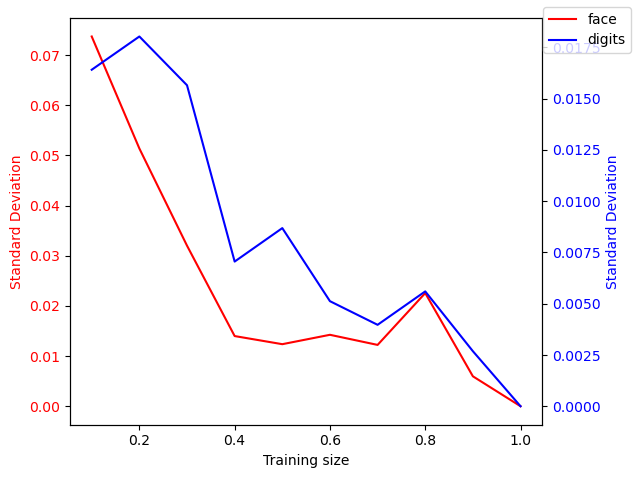

In [150]:
# plot the standard deviations versus the partitions

# plt.plot(partitions, accuracy_std)
# plt.xlabel("Partition")
# plt.ylabel("Standard deviation of accuracy")
# plt.title("Standard deviation of accuracy vs Partition")
# plt.show()

fig, ax1 = plt.subplots()

ax1.set_xlabel("Training size")
ax1.set_ylabel("Standard Deviation", color = 'r')
ax1.plot(partitions, accuracy_std, color = 'r', label = "face")
ax1.tick_params(axis='y', labelcolor='r')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Standard Deviation', color='b')  # we already handled the x-label with ax1
ax2.plot(partitions, accuracy_std2, color='b', label = "digits")
ax2.tick_params(axis='y', labelcolor='b')
fig.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()